<a href="https://colab.research.google.com/github/cocobridge696/ML/blob/main/MNIST_Aclust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Autoencode clustering**

**Theory**

Encode input features into smaller dimensional vector then decode it to same dimensions as input. Then minimize difference between input and output. So the model tries to recreate the input from the smaller dimensional latent vector (final encoder layer). This smaller dimensional data can be used to cluster the data.

Useful link - https://www.youtube.com/watch?v=g-KVHf0A2kI

similarity measure and auxiliary target distribution from - https://towardsdatascience.com/paper-summary-unsupervised-deep-embedding-for-clustering-analysis-e269aed77c6b

In [ ]:
#Load data and normalize

import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense,Input,Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model as plot
import pandas as pd

(train,trlabel),(test,telabel)=tf.keras.datasets.mnist.load_data()

train=np.concatenate((train,test))
trlabel=np.concatenate((trlabel,telabel))

train=(train/255).astype('float32')
test=(test/255).astype('float32')

train=train.reshape(-1,784)
test=test.reshape(-1,784)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
print(train.shape)

(70000, 784)


In [ ]:
#Model

input=Input(shape=(784,))
encode1=Dense(500,activation='relu',kernel_initializer='glorot_uniform')(input)
encode2=Dense(500,activation='relu')(encode1)
encode3=Dense(2000,activation='relu')(encode2)
encode4=Dense(10,activation='relu')(encode3)
decode1=Dense(2000,activation='relu')(encode4)
decode2=Dense(500,activation='relu')(decode1)
decode3=Dense(500,activation='relu')(decode2)
output=Dense(784,activation='relu')(decode3)

auto_encoder=tf.keras.models.Model(inputs=input,outputs=output)
auto_encoder.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
auto_encoder.fit(x=train,y=train,epochs=200,batch_size=256)

Epoch 1/200
274/274 [==============================] - 31s 114ms/step - loss: 0.0419
Epoch 2/200
274/274 [==============================] - 31s 114ms/step - loss: 0.0219
Epoch 3/200
274/274 [==============================] - 32s 115ms/step - loss: 0.0192
Epoch 4/200
274/274 [==============================] - 31s 115ms/step - loss: 0.0177
Epoch 5/200
274/274 [==============================] - 31s 114ms/step - loss: 0.0168
Epoch 6/200
274/274 [==============================] - 32s 116ms/step - loss: 0.0161
Epoch 7/200
274/274 [==============================] - 31s 113ms/step - loss: 0.0157
Epoch 8/200
274/274 [==============================] - 31s 113ms/step - loss: 0.0152
Epoch 9/200
274/274 [==============================] - 31s 113ms/step - loss: 0.0149
Epoch 10/200
274/274 [==============================] - 31s 113ms/step - loss: 0.0146
Epoch 11/200
274/274 [==============================] - 31s 113ms/step - loss: 0.0142
Epoch 12/200
274/274 [==============================] - 31s 113

In [ ]:
#seperate encode model to acquire latent vectors and decode model to look at reconstructions
encoder=Model(inputs=input,outputs=encode4)

input2=Input(shape=(10,))
decode1=auto_encoder.layers[-4](input2)
decode2=(auto_encoder.layers[-3])(decode1)
decode3=auto_encoder.layers[-2](decode2)
decode4=auto_encoder.layers[-1](decode3)

decoder=Model(inputs=input2,outputs=decode4)

In [ ]:
latent_vect=encoder.predict(test)

recons_img=decoder.predict(latent_vect)

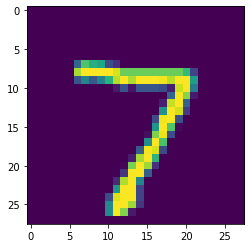

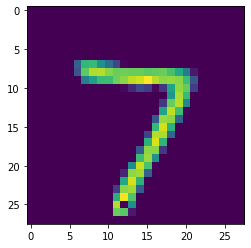

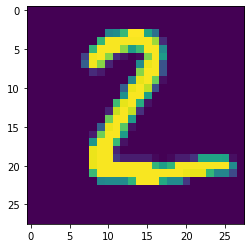

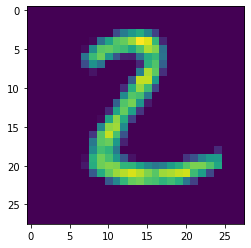

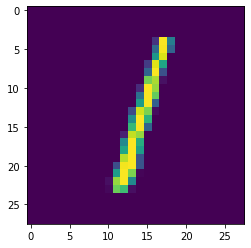

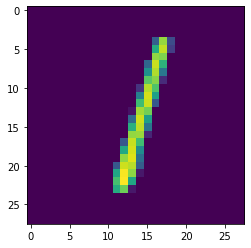

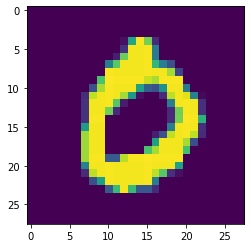

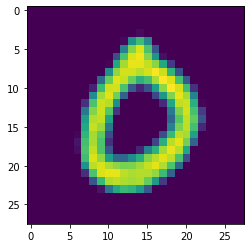

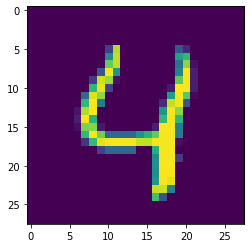

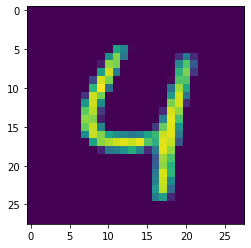

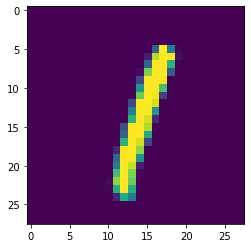

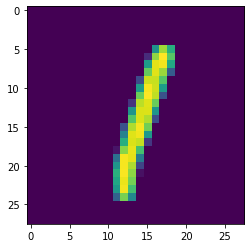

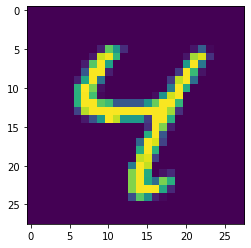

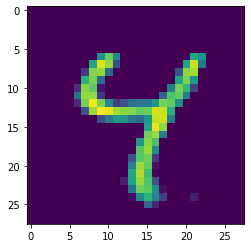

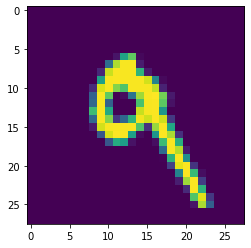

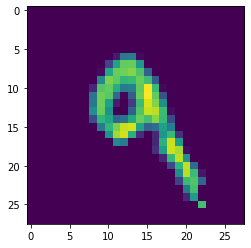

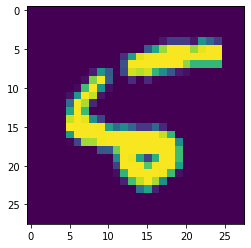

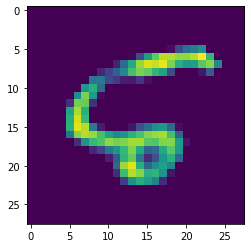

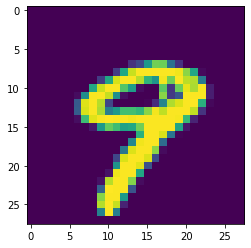

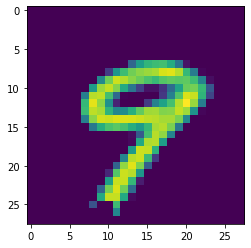

In [ ]:
n=10
for i in range(n):
  plt.figure()
  plt.imshow(test[i].reshape(28,28))
  plt.figure()
  plt.imshow(recons_img[i].reshape(28,28))

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import InputSpec,Layer
class Cluster_lay(Layer):
  def __init__(self,No_clusters,weights=None,alpha=1.0,**kwargs):
    if 'input_shape' not in kwargs and 'input_dim' in kwargs:
      kwargs['input_shape']=(kwargs.pop('input_dim'),)
    super(Cluster_lay,self).__init__(**kwargs)
    self.No_clusters=No_clusters
    self.alpha=alpha
    self.initial_weights=weights
    self.input_spec=InputSpec(ndim=2)

  def build(self,input_shape):
    assert len(input_shape)==2
    input_dim=input_shape[1]
    self.input_spec=InputSpec(dtype=K.floatx(), shape=(None, input_dim))
    self.clusters = self.add_weight(shape=(self.No_clusters,input_dim), initializer='glorot_uniform', name='clusters')
    if self.initial_weights is not None:
      self.set_weights(self.initial_weights)
      del self.initial_weights
      self.built = True

  def call(self,inputs,**kwargs):
    #student t distribution to measure similarity between embedde point and centroid
    q=1.0/(1.0+(K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
    q**=(self.alpha+1.0)/2.0
    q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
    return q

  def compute_output_shape(self, input_shape):
    assert input_shape and len(input_shape) == 2
    return input_shape[0], self.n_clusters

  def get_config(self):
    config = {'n_clusters': self.No_clusters}
    base_config = super(ClusteringLayer, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))


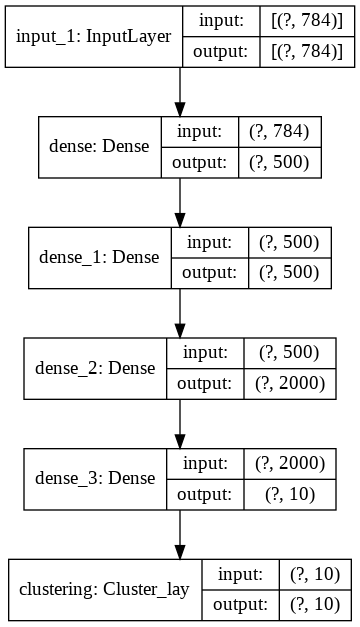

In [ ]:
No_clusters=10
cluster_layer=Cluster_lay(No_clusters,name='clustering')(encoder.output)
model=Model(inputs=encoder.input,outputs=cluster_layer)
plot(model,show_shapes=True)

In [ ]:
#set inital centroids
from sklearn.cluster import KMeans

kmean=KMeans(n_clusters=No_clusters,n_init=20)
centers=kmean.fit_predict(encoder.predict(train))
model.get_layer(name='clustering').set_weights([kmean.cluster_centers_])
model.compile(optimizer=tf.keras.optimizers.SGD(0.01,0.9),loss='kld')

In [ ]:
#auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [ ]:
#takes a long time to run

from sklearn.metrics import accuracy_score as acc

maxiter = 8000
update_interval = 140
index=0
index_array=np.arange(train.shape[0])
batch_size=256
for ite in range(int(maxiter)):
  if ite % update_interval == 0:
    q = model.predict(train, verbose=0)# gives probabilty of each cluster
    p = target_distribution(q)  # update the auxiliary target distribution p

    # evaluate the clustering performance
    #predictions
    y_pred = q.argmax(1) #gives indicie of maximum probability on axis 1
    #As we have labels we can compare cluster performance
    
    #print(acc(trlabel,y_pred),ite)
    
  #train through batches
  idx = index_array[index * batch_size: min((index+1) * batch_size, train.shape[0])]
  loss = model.train_on_batch(x=train[idx], y=p[idx])
  index = index + 1 if (index + 1) * batch_size <= train.shape[0] else 0


# Adjusted Rand Score

In [ ]:
#One accuracy measure
from sklearn import metrics
metrics.adjusted_rand_score(list(trlabel),y_pred)

0.819832347732918

# Munkres' Assingment algorith for accuracy

In [ ]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = np.array(trlabel).astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)   #7*7 matrix
# Creates confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1 #goes through all y_pred and adds one to the correct cell
ind = linear_assignment(-w)   #applys munkes algorith

M_acc=sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

cor_labl=w.argmax(1)
print('The accuracy is {}%'.format(np.round(M_acc*100,2)))
print('The changed cluster labels are {}'.format(cor_labl))

# Silhouette Score

In [ ]:
#Another accuracy measure
from sklearn.metrics import silhouette_score
score=silhouette_score(train,y_pred,metric='euclidean')
print('The silhouette score is {}'.format(score))

# Most common ground truth label accuracy measure 

In [ ]:
#highest number represents most common label in each cluster 
conf=metrics.confusion_matrix(list(trlabel), y_pred)
plt.figure(figsize=(16, 14))
sns.heatmap(conf, annot=True, fmt="d", annot_kws={"size": 20});

In [ ]:
#using most common ground truth label to relabel clusters
print(y_pred[:10])
copy_y_pred=y_pred
#cluster label is different than trlabel as the cluster for number 5 may have a cluster name of 2 etc

#need to relabel them
#code to convert cluster label to number label
num_labl=[0 for x in range(10)]
for n in range(10):
  list1=[]
  index=0
  for x in y_pred:
    if x==n:
      list1.append(index)
    index+=1
  list2= trlabel[list1].tolist()
  print(list2[:20])
  num_labl[n]=max(list2,key=list2.count)

The silhouette score is 0.048742569983005524
[7 4 6 3 8 1 3 5 3 8]
[8, 8, 8, 8, 8, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
[2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3]
[4, 4, 7, 4, 4, 4, 4, 9, 9, 4, 9, 4, 9, 9, 4, 4, 4, 9, 4, 9]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[9, 4, 9, 9, 4, 9, 9, 9, 4, 9, 9, 4, 9, 4, 4, 4, 4, 9, 4, 4]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7]


In [ ]:
print(num_labl)

[8, 2, 6, 1, 0, 3, 4, 5, 9, 7]


In [ ]:
#change labels
for x in range(len(y_pred)):
  value=y_pred[x]
  y_pred[x]=num_labl[value]


In [ ]:
print(y_pred)
accuracy=acc(trlabel,y_pred)
print('The accuracy is {}%'.format(int(accuracy*100)))

[5 0 4 ... 9 5 6]
The accuracy is 87%


In [ ]:
print(trlabel[:20])

print(y_pred[:20])

Typically, clustering is used on unlabeled data so accuracy could only be measure by using metrics such as sillhouete score